In [1]:
import pandas as pd
import numpy as np
import scipy.signal
import sys
import os
import matplotlib.pyplot as plt
import plotly.express as px
import neurokit2 as nk


In [2]:
cur_dir = os.getcwd()
dataset_path = os.path.join(cur_dir, "../Dataset")
print(dataset_path)
sys.path.append(dataset_path)

d:\УЧЕБА\Remote monitoring\Scripts\../Dataset


In [3]:
from importlib import reload
import ECGsignal as ecg

reload(ecg)

ecg.init()

In [4]:
test_ecg = ecg.signal(2)

In [ ]:
ecg.plot_signal(2)

In [6]:
df = pd.DataFrame()
start =  0
end = len(test_ecg[0])
df['ECG I'] = test_ecg[0][start:end]
df['ECG II'] = test_ecg[1][start:end]
df['ECG V1'] = test_ecg[6][start:end]
df['ECG V2'] = test_ecg[7][start:end]
df['ECG V3'] = test_ecg[8][start:end]
df['ECG V4'] = test_ecg[9][start:end]
df['ECG V5'] = test_ecg[10][start:end]
df['ECG V6'] = test_ecg[11][start:end]

df.tail()

,ECG I,ECG II,ECG V1,ECG V2,ECG V3,ECG V4,ECG V5,ECG V6
2495,0.030,0.090,0.010,0.020,-0.065,-0.015,0.005,-0.005
2496,0.030,0.090,0.014,0.019,-0.065,-0.011,0.005,-0.005
2497,0.033,0.093,0.015,0.023,-0.065,-0.010,0.005,-0.005
2498,0.035,0.095,0.015,0.025,-0.065,-0.010,0.005,-0.005
2499,0.036,0.096,0.015,0.026,-0.064,-0.010,0.006,-0.004


In [11]:
cancel_showing = False
plot_3D = True
filt = True
f_sreza = 1.5
channels = df.columns
fs = 500
Fs_new = fs

In [12]:

## Поиск точек PQRST:
n_otvedenie = 'I'
signal = np.array(df['ECG I'])  
time_new = len(signal) / Fs_new

# способ чистить сигнал перед поиском пиков:
signal = nk.ecg_clean(signal, sampling_rate=Fs_new, method="neurokit") 

# Поиск R зубцов:
_, rpeaks = nk.ecg_peaks(signal, sampling_rate=Fs_new)

    # Проверка в случае отсутствия результатов и повторная попытка:
if rpeaks['ECG_R_Peaks'].size <= 5:
    print("На I отведении не удалось детектировать R зубцы")
    print("Проводим детектирование по II отведению:")
    n_otvedenie = 'II'
    signal = np.array(df['ECG II'])  
    signal = nk.ecg_clean(signal, sampling_rate=Fs_new, method="neurokit") 
    _, rpeaks = nk.ecg_peaks(signal, sampling_rate=Fs_new)
        
    # При повторной проблеме выход из функции:
    if rpeaks['ECG_R_Peaks'].size <= 3:
        print('Сигналы ЭКГ слишком шумные для анализа')
        # Отобразим эти шумные сигналы:
        if not cancel_showing:
            num_channels = len(channels)
            fig, axs = plt.subplots(int(num_channels/2), 2, figsize=(11, 8), sharex=True)
            for i, graph in enumerate(channels):
                row = i // 2
                col = i % 2
                sig = np.array(df[graph])
                axs[row, col].plot(time_new, sig)
                axs[row, col].set_title(graph)
                axs[row, col].set_xlim([0, 6])
                axs[row, col].set_title(graph)
                axs[row, col].set_xlabel('Time (seconds)')
            plt.tight_layout()
            plt.show()
            plt.ioff()
            plt.show()
        raise Exception("НЕ могу определить RR")


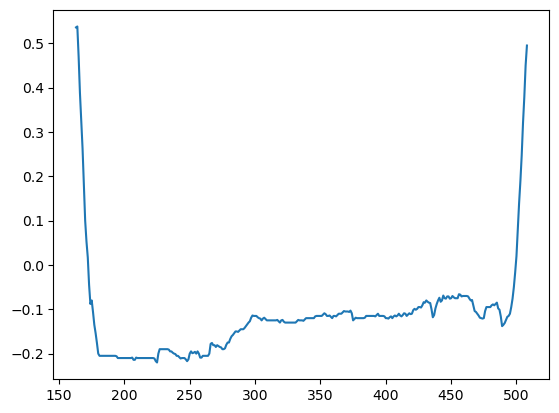

In [13]:
plt.plot(df['ECG I'][rpeaks['ECG_R_Peaks'][0]:rpeaks['ECG_R_Peaks'][1]] )
#plt.plot(test_ecg[0][449:858])

In [15]:
# ФВЧ фильтрация артефактов дыхания:
if filt == True:
    df_new = pd.DataFrame()
    for graph in channels:
        sig = np.array(df[graph])
        sos = scipy.signal.butter(1, f_sreza, 'hp', fs=Fs_new, output='sos')
        avg = np.mean(sig)
        filtered = scipy.signal.sosfilt(sos, sig)
        filtered += avg
        df_new[graph] = pd.Series(filtered)
    df = df_new.copy()
        
    # ФНЧ фильтрация (по желанию можно включить):
filt_low_pass = False
if filt_low_pass:
    df_new = pd.DataFrame()
    for graph in channels:
        sig = np.array(df[graph])
        sos = scipy.signal.butter(1, 100, 'lp', fs=Fs_new, output='sos')
        avg = np.mean(sig)
        filtered = scipy.signal.sosfilt(sos, sig)
        filtered += avg
        df_new[graph] = pd.Series(filtered)
    df = df_new.copy()


In [16]:
def make_vecg(df_term):
    # Получает значения ВЭКГ из ЭКГ
    DI = df_term['ECG I']
    DII = df_term['ECG II']
    V1 = df_term['ECG V1']
    V2 = df_term['ECG V2']
    V3 = df_term['ECG V3']
    V4 = df_term['ECG V4']
    V5 = df_term['ECG V5']
    V6 = df_term['ECG V6']

    df_term['x'] = -(-0.172*V1-0.074*V2+0.122*V3+0.231*V4+0.239*V5+0.194*V6+0.156*DI-0.01*DII)
    df_term['y'] = (0.057*V1-0.019*V2-0.106*V3-0.022*V4+0.041*V5+0.048*V6-0.227*DI+0.887*DII)
    df_term['z'] = -(-0.229*V1-0.31*V2-0.246*V3-0.063*V4+0.055*V5+0.108*V6+0.022*DI+0.102*DII)
    return df_term

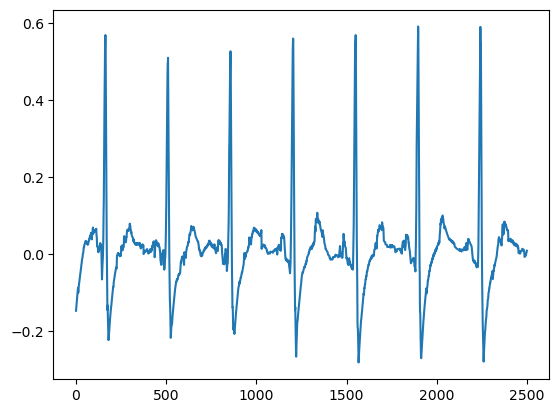

In [17]:
plt.plot(df['ECG I'])

In [19]:
# Расчет ВЭКГ
df_term = make_vecg(df)
#df = make_vecg(df)
df_term['size'] = end - start # задание размера для 3D визуализации

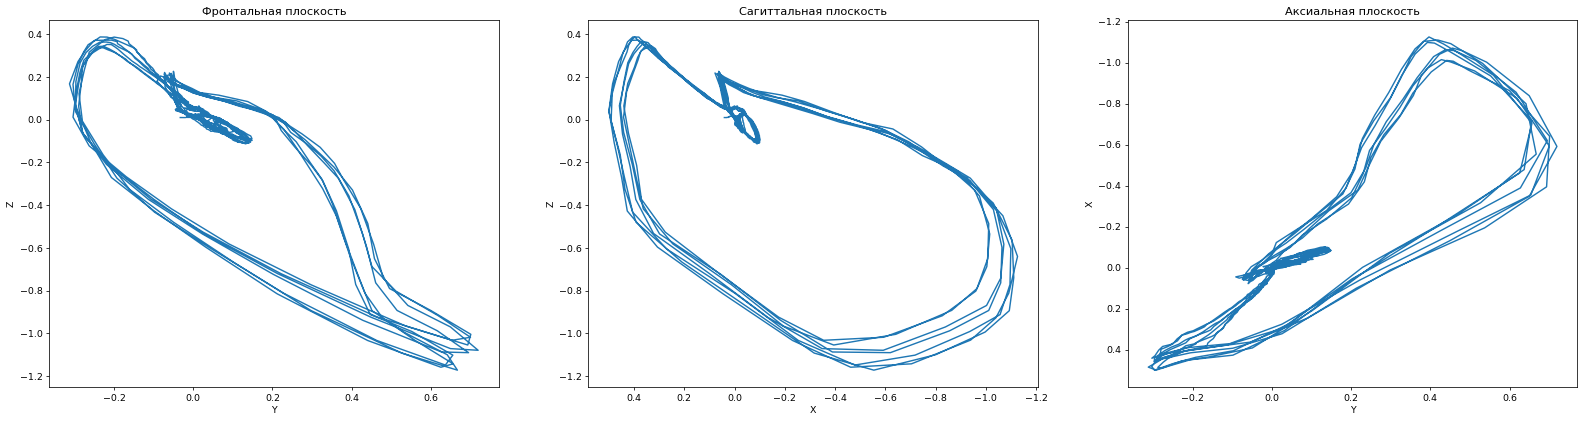

In [20]:
if not cancel_showing:
        plt.figure(figsize=(29, 7), dpi=68)
        plt.subplot(1, 3, 1)
        plt.plot(df_term.y, df_term.z)
        plt.title('Фронтальная плоскость')
        plt.xlabel('Y')
        plt.ylabel('Z')

        plt.subplot(1, 3, 2)
        plt.gca().invert_xaxis()
        plt.plot(df_term.x, df_term.z)
        plt.title('Сагиттальная плоскость')
        plt.xlabel('X')
        plt.ylabel('Z')

        plt.subplot(1, 3, 3)
        plt.plot(df_term.y, df_term.x)
        plt.title('Аксиальная плоскость')  
        plt.gca().invert_yaxis()
        plt.xlabel('Y')
        plt.ylabel('X')
        plt.show()

    # Интерактивное 3D отображение
if plot_3D:
    fig = px.scatter_3d(df_term, x='x', y='y', z='z', size='size', size_max=10, opacity=1)
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    fig.show()